<a href="https://colab.research.google.com/github/rocodoco20/AI1week/blob/main/cuda_psy_1Hweek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms

In [47]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Files already downloaded and verified


##[MY CODE] Test data 준비하기 train False

10000
torch.Size([3, 32, 32]) 3


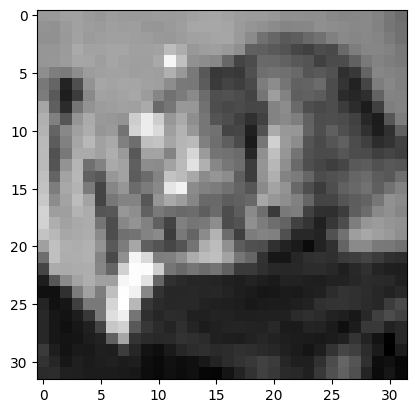

In [40]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

In [56]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

[MY CODE] Test data 준비하기 shuffle False

In [57]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [58]:
from torch import nn

class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 1)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(32 * 32 * 3, 1024)

##[MY CODE] model = Model(32 * 32 * 3, 1024)으로 변경

In [59]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = (preds[:, 0] - labels).pow(2).mean()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 1929.977165222168
Epoch   1 | Loss: 1709.349934577942
Epoch   2 | Loss: 1639.7503514289856
Epoch   3 | Loss: 1587.4300475120544
Epoch   4 | Loss: 1552.8486766815186
Epoch   5 | Loss: 1525.2044467926025
Epoch   6 | Loss: 1504.1857604980469
Epoch   7 | Loss: 1488.6611061096191
Epoch   8 | Loss: 1478.1135425567627
Epoch   9 | Loss: 1469.7326254844666
Epoch  10 | Loss: 1461.770929813385
Epoch  11 | Loss: 1444.585039138794
Epoch  12 | Loss: 1434.363492012024
Epoch  13 | Loss: 1427.1598110198975
Epoch  14 | Loss: 1417.7599077224731
Epoch  15 | Loss: 1406.013011455536
Epoch  16 | Loss: 1401.033278465271
Epoch  17 | Loss: 1392.8697910308838
Epoch  18 | Loss: 1379.612144947052
Epoch  19 | Loss: 1372.9104733467102
Epoch  20 | Loss: 1368.2996530532837
Epoch  21 | Loss: 1362.3470940589905


##[MY CODE] n_epochs = 50 으로 변경

In [54]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)